# Turning Points and Peaks Analysis

## Notebook Summary
- Loads cleaned experiment tracking data and calibrates depth borders for layer mapping.
- Detects peaks and turning points in depth trajectories across conditions and target layers.
- Computes summary statistics and box-plot inputs by condition, result layer, and detected peak layer.
- Exports aggregated data and visualizations, including per-trial interaction graphs with trimmed idle phases.


## Imports and Helper Functions
Load shared imports, global paths, plotting configuration, and helper functions from `functions.ipynb`.


In [1]:
# Load shared imports, constants, and helper functions used across notebooks.
%run functions.ipynb


## Load Experiment Data
Read the merged experiment tracking dataset (`export/data/data_experiment.csv`) used in the turning-point analysis.


In [2]:
# Load merged experiment tracking data used for turning-point analysis.
data_complete = pd.read_csv(rf'{export_data}data_experiment.csv', sep=";")

display(data_complete)


,Date,ProbandId,Block,Trial,TrialNumber,Condition,ResultNumber,ResultLayer,ProgramState,ProgramSubState,...,Layer03,Layer04,Layer05,Layer06,Layer07,file,SubStateChange,StateChange,TrialChange,StateChangeMarker
0,2022-08-01 14:12:39.590,2,0,0,0,No Feedback,166,5,4,0,...,130,139,166,150,132,P02_2022-08-01,-2.0,1.0,-1.0,START_BLOCK | START_EXPERIMENT
1,2022-08-01 14:12:39.635,2,0,0,0,No Feedback,166,5,4,0,...,130,139,166,150,132,P02_2022-08-01,0.0,0.0,0.0,-
2,2022-08-01 14:12:39.651,2,0,0,0,No Feedback,166,5,4,0,...,130,139,166,150,132,P02_2022-08-01,0.0,0.0,0.0,-
3,2022-08-01 14:12:39.683,2,0,0,0,No Feedback,166,5,4,0,...,130,139,166,150,132,P02_2022-08-01,0.0,0.0,0.0,-
4,2022-08-01 14:12:39.696,2,0,0,0,No Feedback,166,5,4,0,...,130,139,166,150,132,P02_2022-08-01,0.0,0.0,0.0,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2890534,2022-08-23 11:30:05.409,23,3,20,83,No Feedback,169,7,4,2,...,137,130,150,143,169,P23_2022-08-23,0.0,0.0,0.0,-
2890535,2022-08-23 11:30:05.440,23,3,20,83,No Feedback,169,7,4,2,...,137,130,150,143,169,P23_2022-08-23,0.0,0.0,0.0,-
2890536,2022-08-23 11:30:05.472,23,3,20,83,No Feedback,169,7,4,2,...,137,130,150,143,169,P23_2022-08-23,0.0,0.0,0.0,-
2890537,2022-08-23 11:30:05.503,23,3,20,83,No Feedback,169,7,4,2,...,137,130,150,143,169,P23_2022-08-23,0.0,0.0,0.0,-


## Compute Layer Borders
Derive minimum and maximum `PosZ` values for each layer to map detected peaks back to interaction layers.


In [3]:
layers = data_complete["Layer"].drop_duplicates().drop(0)

layer_ranges = []

# Build per-layer depth boundaries from observed PosZ values.
for layer in layers:
    layer_min = data_complete[data_complete["Layer"] == layer]["PosZ"].min()
    layer_max = data_complete[data_complete["Layer"] == layer]["PosZ"].max()
    layer_ranges.append([layer, layer_min, layer_max])

borders = pd.DataFrame(layer_ranges, columns=['Layer', 'Min', 'Max'])
# Normalize numeric types so range checks work reliably downstream.
borders['Min'] = borders['Min'].astype(float)
borders['Max'] = borders['Max'].astype(float)

display(borders)

# Persist borders so other notebooks can reuse the same layer mapping.
borders.to_csv(rf'{export_data}borders.csv', sep=";", index=False)


,Layer,Min,Max
0,0,-0.004,-0.124000
1,1,-0.128,-0.248000
2,2,-0.252,-0.372000
3,3,-0.376,-0.496000
4,4,-0.500,-0.624000
5,5,-0.628,-0.748000
6,6,-0.752,-0.872000
7,7,-0.876,-1.000001


## Helper: Map Depth to Layer
Define a helper function that assigns a depth (`PosZ`) value to the corresponding calibrated layer interval.


In [4]:
def getLayer(borders, zStr):
    # Convert depth value from string input to numeric for interval lookup.
    zValue = float(zStr)

    # Find the layer interval that contains the depth value.
    l = borders[(borders['Min'] > zValue) & (borders['Max'] < zValue)]
    if len(l) == 0:
        # Return 0 when the value does not map to any calibrated layer.
        return 0
    return l['Layer'].values[0]


## Extract Peaks for One Configuration
Create a function that filters one condition/target-layer subset, detects peaks with two methods, and returns per-trial peak records.


In [5]:
def extractAllPeaks(condition, target):
   # Restrict data to one condition/target-layer pair during active interaction.
   exp_data_complete = data_complete[(data_complete['ResultLayer'] == target) & (data_complete['Condition'] == condition) & (data_complete['ProgramSubState'] == 1)].reset_index(drop=True).groupby(["ProbandId", "Block", "Trial"])

   # Look up calibrated depth borders of the current target layer.
   min = float(borders.loc[borders['Layer'].astype(int) == target, 'Min'].values[0])
   max = float(borders.loc[borders['Layer'].astype(int) == target, 'Max'].values[0])

   complete = pd.DataFrame()

   for name, group in exp_data_complete:

      result = pd.DataFrame()

      norm = group.reset_index(drop=True)

      # Convert depth signal to numeric values and replace missing markers.
      z_data = np.array(norm["PosZ"].replace("-", 0).astype(float), float)

      # Smooth the signal before local extrema detection.
      filtered = savgol_filter(z_data, 15, 2)

      # Detect extrema with both CWT and prominence-based approaches.
      ex_max2 = find_peaks_cwt(z_data, np.arange(1,55))
      ex_min2 = find_peaks_cwt(-z_data, np.arange(1,55))

      ex_max, _ = find_peaks(filtered, prominence=0.05)
      ex_min, _ = find_peaks(-filtered, prominence=0.05)

      peaks = []
      peaks = np.concatenate([ex_max,ex_min])
      peaks2 = np.concatenate([ex_max2, ex_min2])

      # Resolve detected indices back to their original PosZ values.
      peaks_z = pd.DataFrame(pd.DataFrame(peaks).apply(lambda item: norm.iloc[item]["PosZ"])[0].replace(to_replace='-', value='0').astype(float).fillna(0))
      peaks2_z = pd.DataFrame(pd.DataFrame(peaks2).apply(lambda item: norm.iloc[item]["PosZ"])[0].replace(to_replace='-', value='0').astype(float).fillna(0))

      df_peaks = pd.DataFrame()

      # Map each detected peak depth to a calibrated layer label.
      peaks_layer = []
      for p in peaks_z[0].values:
         l = getLayer(borders, p)
         peaks_layer.append([p, l, 'find_peaks'])

      peaks2_layer = []
      for p in peaks2_z[0].values:
         l = getLayer(borders, p)
         peaks_layer.append([p, l, 'find_peaks_cwt'])

      df_peaks = pd.DataFrame(peaks_layer)
      df_peaks.columns = ['Peak_Z', 'Peak_Layer', 'Method']

      # Attach peak metadata and trial identifiers.
      result['Peak_Z'] = df_peaks['Peak_Z']
      result['Peak_Layer'] = df_peaks['Peak_Layer']
      result['Method'] = df_peaks['Method']

      result["Peaks1_Total"] = len(peaks_z[0].values)
      result["Peaks2_Total"] = len(peaks2_z[0].values)
      result['Peaks_Total'] = len(df_peaks)

      result["ProbandId"] = norm["ProbandId"]
      result["Block"] = norm["Block"]
      result["Trial"] = norm["Trial"]
      result['TrialNumber'] = norm['TrialNumber']
      result['Date'] = norm['Date']

      complete = pd.concat([complete, result])

   # Add static context fields so rows remain self-contained after concatenation.
   complete["Condition"] = condition
   complete["ResultLayer"] = int(target)
   complete["ResultLayer_Relative"] = int(target) / 7.0
   complete["ResultLayer_Center"] = -0.5 * (min + max)

   return complete

# test
peaks_df = extractAllPeaks("Combined Feedback", 6)
display(peaks_df)


/opt/anaconda3/lib/python3.11/site-packages/scipy/signal/_peak_finding.py:1192: RuntimeWarning: divide by zero encountered in scalar divide
  snr = abs(cwt[line[0][0], line[1][0]] / noises[line[1][0]])
/opt/anaconda3/lib/python3.11/site-packages/scipy/signal/_peak_finding.py:1192: RuntimeWarning: divide by zero encountered in scalar divide
  snr = abs(cwt[line[0][0], line[1][0]] / noises[line[1][0]])
/opt/anaconda3/lib/python3.11/site-packages/scipy/signal/_peak_finding.py:1192: RuntimeWarning: divide by zero encountered in scalar divide
  snr = abs(cwt[line[0][0], line[1][0]] / noises[line[1][0]])


,Peak_Z,Peak_Layer,Method,Peaks1_Total,Peaks2_Total,Peaks_Total,ProbandId,Block,Trial,TrialNumber,Date,Condition,ResultLayer,ResultLayer_Relative,ResultLayer_Center
0,-0.008000,0,find_peaks,5,28,33,2,1,0,21,2022-08-01 14:35:36.902,Combined Feedback,6,0.857143,0.812
1,0.000000,0,find_peaks,5,28,33,2,1,0,21,2022-08-01 14:35:36.934,Combined Feedback,6,0.857143,0.812
2,-0.100000,0,find_peaks,5,28,33,2,1,0,21,2022-08-01 14:35:36.962,Combined Feedback,6,0.857143,0.812
3,-0.112000,0,find_peaks,5,28,33,2,1,0,21,2022-08-01 14:35:36.994,Combined Feedback,6,0.857143,0.812
4,-1.000001,7,find_peaks,5,28,33,2,1,0,21,2022-08-01 14:35:37.025,Combined Feedback,6,0.857143,0.812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,-0.512000,4,find_peaks_cwt,1,19,20,23,1,6,27,2022-08-23 10:52:02.803,Combined Feedback,6,0.857143,0.812
16,-0.652000,5,find_peaks_cwt,1,19,20,23,1,6,27,2022-08-23 10:52:02.836,Combined Feedback,6,0.857143,0.812
17,-0.804001,6,find_peaks_cwt,1,19,20,23,1,6,27,2022-08-23 10:52:02.868,Combined Feedback,6,0.857143,0.812
18,-0.848000,6,find_peaks_cwt,1,19,20,23,1,6,27,2022-08-23 10:52:02.897,Combined Feedback,6,0.857143,0.812


## Plot and Trim a Single Trial
Define a plotting helper that removes leading/trailing idle samples, detects extrema, and exports one interaction graph per trial.


/var/folders/94/jmc3f73x53bbbvrrms8z445m0000gn/T/ipykernel_82966/996776013.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


['2022-08-01 14:35:40.270', '2022-08-01 14:36:18.437']

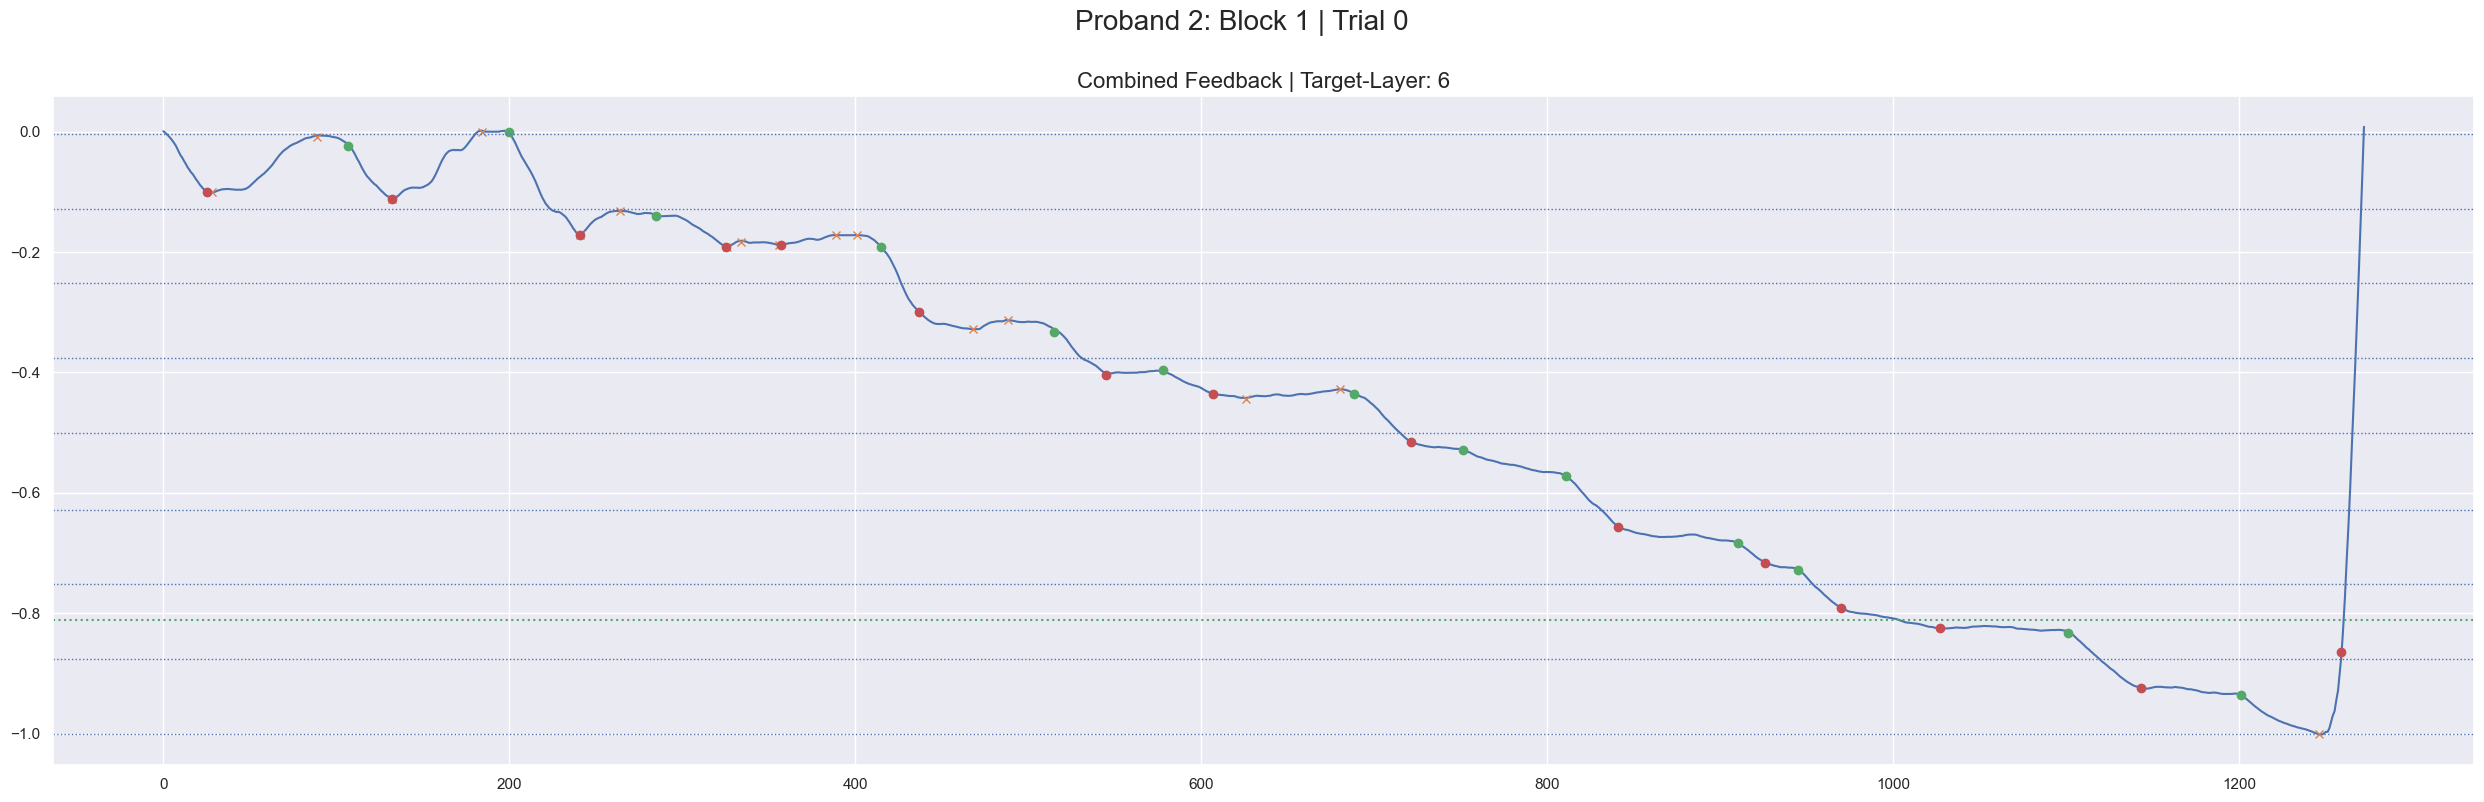

In [6]:
def drawInteractionGraph(probandId, trialNumber, show=False):

   exp_data = data_complete[(data_complete['ProbandId'] == probandId) & (data_complete['TrialNumber'] == trialNumber)].reset_index(drop=True)

   block = exp_data['Block'][0]
   trial = exp_data['Trial'][0]

   condition = exp_data['Condition'][0]

   target = exp_data['ResultLayer'].values[0]

   min = float(borders.loc[borders['Layer'].astype(int) == target, 'Min'].values[0])
   max = float(borders.loc[borders['Layer'].astype(int) == target, 'Max'].values[0])

   # Trim leading idle samples encoded as '-'.
   exp_data = exp_data[(exp_data.PosZ != "-").idxmax():].reset_index(drop=True)

   # Reverse and trim again to remove trailing idle samples.
   exp_data = exp_data.loc[::-1].reset_index(drop=True)
   exp_data = exp_data[(exp_data.PosZ != "-").idxmax():].reset_index()

   # Restore original chronological order after trimming.
   exp_data = exp_data.loc[::-1].reset_index(drop=True)

   date_start = exp_data['Date'][0]
   date_stop = exp_data.tail(1)['Date'].values[0]

   # Prepare filtered depth signal for peak extraction and plotting.
   z_data = exp_data["PosZ"].replace("-", 0).astype(float)
   filtered = savgol_filter(z_data, 15, 2)

   ex_max2 = find_peaks_cwt(filtered, np.arange(1,55))
   ex_min2 = find_peaks_cwt(-filtered, np.arange(1,55))

   ex_max, _ = find_peaks(filtered, prominence=0.005)
   ex_min, _ = find_peaks(-filtered, prominence=0.005)

   peaks = np.concatenate([ex_max,ex_min])

   fig,ax = plt.subplots(1, 1, tight_layout=True, figsize=(25,8), clear=True)

   ax.plot(exp_data.index, filtered, label='Depth_filtered')
   ax.plot(peaks, z_data[peaks], "x")
   ax.plot(ex_max2, z_data[ex_max2], "o")
   ax.plot(ex_min2, z_data[ex_min2], "o")

   # Draw calibrated layer borders and the center line of the target layer.
   for i, row in borders.iterrows():

      ax.axhline(y=float(row['Min']), linestyle=":", linewidth=1)
      if i == len(borders) - 1:
         ax.axhline(y=float(row['Max']), linestyle=":", linewidth=1)

   ax.axhline(y=0.5 * (max + min), linestyle=":", color='g')

   plt.suptitle(f'Proband {probandId}: Block {block} | Trial {trial}',fontsize=20, y=1)
   plt.title(f'{condition} | Target-Layer: {target}',fontsize=16)

   # Export each trial graph for later visual inspection and reporting.
   plt.savefig(rf'{export_img_single}Interaction_p{probandId}_{trialNumber}.jpg')
   plt.savefig(rf'{export_img_single}Interaction_p{probandId}_{trialNumber}.svg')

   if show:
      fig.show()
   else:
      plt.close(fig)

   return [date_start, date_stop]

# test
peaks_df = drawInteractionGraph(2,21, True)
display(peaks_df)


## Run Extraction Across Conditions and Layers
Iterate over all condition and result-layer combinations, collect extracted peaks, and save the combined output table.


In [7]:
all_layers = np.array(data_complete["ResultLayer"].drop_duplicates().sort_values())
all_conditions = np.array(data_complete["Condition"].drop_duplicates().sort_values())

result_all = pd.DataFrame()

# Run extraction for every condition/layer combination and combine all rows.
for c in all_conditions:
    for t in all_layers:
        p = extractAllPeaks(c, t)
        result_all = pd.concat([result_all, p])

# Keep output sorted for reproducible downstream exports and plots.
result_all = result_all.sort_values(['ProbandId', 'TrialNumber'])

display(result_all)

# Persist full peaks table for reuse by other analysis cells/notebooks.
savePeaks(result_all)


/opt/anaconda3/lib/python3.11/site-packages/scipy/signal/_peak_finding.py:1192: RuntimeWarning: divide by zero encountered in scalar divide
  snr = abs(cwt[line[0][0], line[1][0]] / noises[line[1][0]])
/opt/anaconda3/lib/python3.11/site-packages/scipy/signal/_peak_finding.py:1192: RuntimeWarning: divide by zero encountered in scalar divide
  snr = abs(cwt[line[0][0], line[1][0]] / noises[line[1][0]])
/opt/anaconda3/lib/python3.11/site-packages/scipy/signal/_peak_finding.py:1192: RuntimeWarning: divide by zero encountered in scalar divide
  snr = abs(cwt[line[0][0], line[1][0]] / noises[line[1][0]])
/opt/anaconda3/lib/python3.11/site-packages/scipy/signal/_peak_finding.py:1192: RuntimeWarning: divide by zero encountered in scalar divide
  snr = abs(cwt[line[0][0], line[1][0]] / noises[line[1][0]])
/opt/anaconda3/lib/python3.11/site-packages/scipy/signal/_peak_finding.py:1192: RuntimeWarning: divide by zero encountered in scalar divide
  snr = abs(cwt[line[0][0], line[1][0]] / noises[lin

,Peak_Z,Peak_Layer,Method,Peaks1_Total,Peaks2_Total,Peaks_Total,ProbandId,Block,Trial,TrialNumber,Date,Condition,ResultLayer,ResultLayer_Relative,ResultLayer_Center
0,-0.128,0,find_peaks,17,66,83,2,0,0,0,2022-08-01 14:14:00.583,No Feedback,5,0.714286,0.688000
1,-0.220,1,find_peaks,17,66,83,2,0,0,0,2022-08-01 14:14:00.615,No Feedback,5,0.714286,0.688000
2,0.000,0,find_peaks,17,66,83,2,0,0,0,2022-08-01 14:14:00.645,No Feedback,5,0.714286,0.688000
3,-0.100,0,find_peaks,17,66,83,2,0,0,0,2022-08-01 14:14:00.676,No Feedback,5,0.714286,0.688000
4,0.000,0,find_peaks,17,66,83,2,0,0,0,2022-08-01 14:14:00.707,No Feedback,5,0.714286,0.688000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,-0.576,4,find_peaks_cwt,4,22,26,23,3,20,83,2022-08-23 11:29:33.555,No Feedback,7,1.000000,0.938001
22,-0.644,5,find_peaks_cwt,4,22,26,23,3,20,83,2022-08-23 11:29:33.587,No Feedback,7,1.000000,0.938001
23,-0.848,6,find_peaks_cwt,4,22,26,23,3,20,83,2022-08-23 11:29:33.617,No Feedback,7,1.000000,0.938001
24,-0.992,7,find_peaks_cwt,4,22,26,23,3,20,83,2022-08-23 11:29:33.647,No Feedback,7,1.000000,0.938001


## Condition-Level Peak Statistics
Create boolean peak labels by detection method and compute trial-level peak and turning-point statistics by condition.


Condition,No Feedback,Tactile Feedback,Visual Feedback,Combined Feedback
count,462.000000,462.000000,462.000000,462.000000
mean,35.396104,36.616883,27.846320,28.491342
std,14.766477,16.452864,9.018911,10.379509
min,8.000000,10.000000,14.000000,14.000000
25%,25.000000,25.000000,21.000000,22.000000
50%,32.000000,33.000000,26.000000,26.000000
75%,42.000000,44.000000,33.000000,32.000000
max,125.000000,123.000000,62.000000,108.000000


,0,1,2,3,4
count,462.000000,462.000000,462.000000,462.000000,1848.000000
mean,35.396104,36.616883,27.846320,28.491342,32.087662
std,14.766477,16.452864,9.018911,10.379509,13.593523
min,8.000000,10.000000,14.000000,14.000000,8.000000
5%,19.000000,19.000000,17.000000,17.000000,NaN
10%,21.000000,21.000000,18.000000,19.000000,NaN
25%,25.000000,25.000000,21.000000,22.000000,23.000000
50%,32.000000,33.000000,26.000000,26.000000,28.000000
75%,42.000000,44.000000,33.000000,32.000000,38.000000
90%,54.000000,56.000000,40.900000,41.000000,NaN


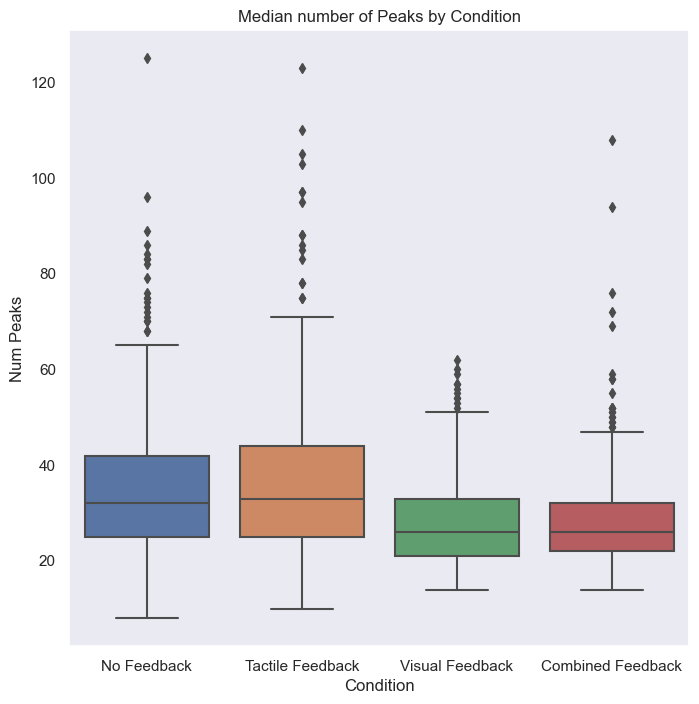

Condition,No Feedback,Tactile Feedback,Visual Feedback,Combined Feedback
count,462.000000,462.000000,462.000000,462.000000
mean,5.883117,6.253247,2.904762,3.147186
std,5.108729,5.979606,2.156466,2.537353
min,1.000000,1.000000,0.000000,0.000000
25%,3.000000,3.000000,1.000000,1.000000
50%,5.000000,5.000000,3.000000,3.000000
75%,9.000000,9.000000,4.000000,5.000000
max,51.000000,37.000000,12.000000,18.000000


,0,1,2,3,4
count,462.000000,462.000000,462.000000,462.000000,1848.000000
mean,5.883117,6.253247,2.904762,3.147186,4.547078
std,5.108729,5.979606,2.156466,2.537353,4.532736
min,1.000000,1.000000,0.000000,0.000000,0.000000
5%,1.000000,1.000000,1.000000,1.000000,NaN
10%,1.000000,1.000000,1.000000,1.000000,NaN
25%,3.000000,3.000000,1.000000,1.000000,1.000000
50%,5.000000,5.000000,3.000000,3.000000,3.000000
75%,9.000000,9.000000,4.000000,5.000000,6.000000
90%,12.000000,13.000000,6.000000,6.900000,NaN


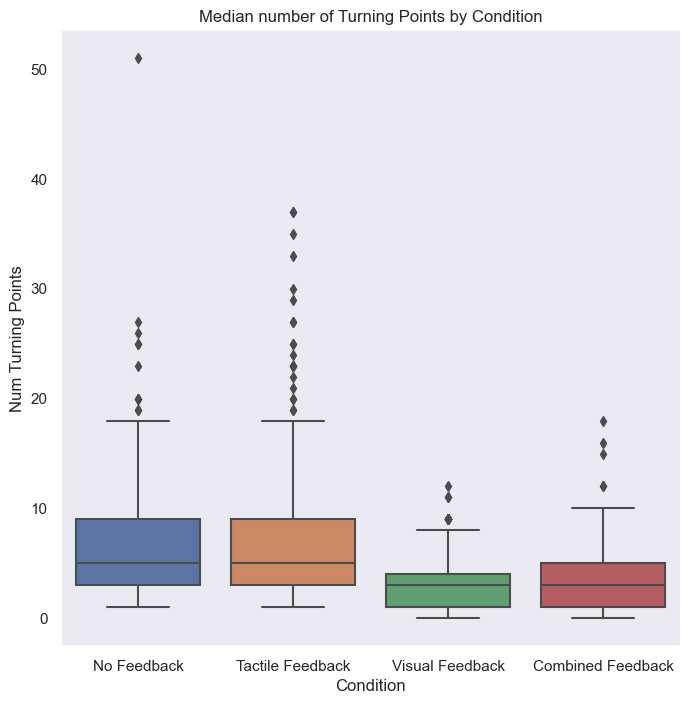

In [8]:
result_all['Peak_Layer'] = result_all['Peak_Layer'].astype(int)

# Convert detection method labels into boolean flags for grouped statistics.
result_all['IsPeak'] = np.where(result_all['Method'] == 'find_peaks_cwt', True, False)
result_all['IsTurningPoint'] = np.where(result_all['Method'] == 'find_peaks', True, False)

# Keep one row per trial-level aggregate to avoid counting duplicate peak rows.
result_partial = result_all[['Condition', 'ProbandId', 'TrialNumber', 'Peaks_Total', 'Peaks1_Total']].drop_duplicates().reset_index()

generateBoxPlotStats(result_partial, ['Condition'], ['ProbandId', 'TrialNumber'], 'Peaks_Total', 'Condition', 'Num Peaks', 'Median number of Peaks by Condition', 'numPeaks_Condition', True, True, True, True)
generateBoxPlotStats(result_partial, ['Condition'], ['ProbandId', 'TrialNumber'], 'Peaks1_Total', 'Condition', 'Num Turning Points', 'Median number of Turning Points by Condition', 'numTurningPoints_Condition', True, True, True, True)


## Result-Layer Peak Statistics
Compute trial-level peak and turning-point statistics grouped by the expected result layer.


ResultLayer,1,2,3,4,5,6,7
count,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000
mean,30.939394,31.170455,32.678030,33.556818,32.488636,32.950758,30.829545
std,12.377618,11.153838,12.710529,14.481028,13.499749,16.246247,13.980884
min,16.000000,8.000000,14.000000,15.000000,15.000000,12.000000,14.000000
25%,23.000000,24.000000,24.000000,24.000000,23.000000,23.000000,22.000000
50%,28.000000,28.000000,30.000000,30.000000,29.000000,27.500000,27.000000
75%,35.250000,36.250000,39.000000,40.000000,39.250000,37.250000,34.250000
max,103.000000,85.000000,86.000000,125.000000,84.000000,108.000000,123.000000


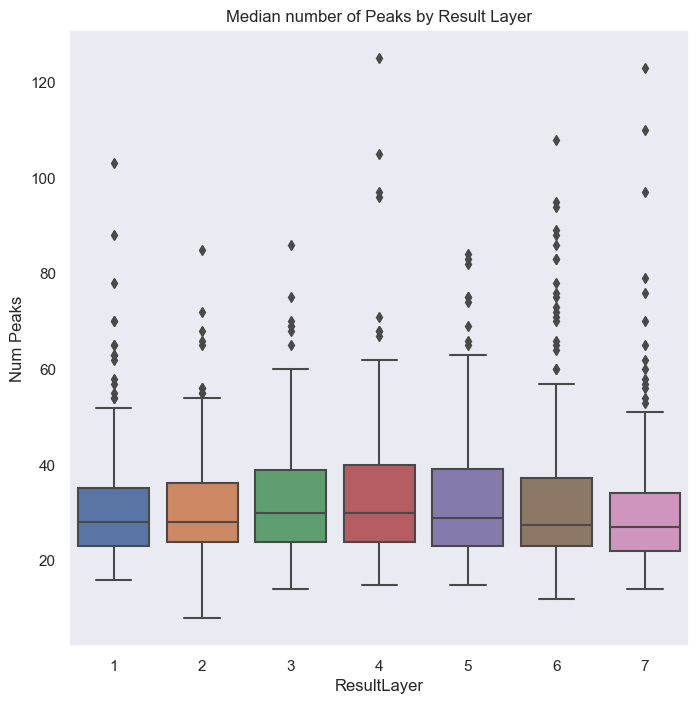

ResultLayer,1,2,3,4,5,6,7
count,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000
mean,4.886364,4.534091,4.553030,4.662879,4.291667,4.553030,4.348485
std,4.544914,3.644723,4.032783,5.081464,4.350841,4.833052,5.073580
min,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,6.250000,6.000000,5.000000,7.000000,6.000000,5.000000,5.000000
max,37.000000,29.000000,27.000000,51.000000,23.000000,26.000000,37.000000


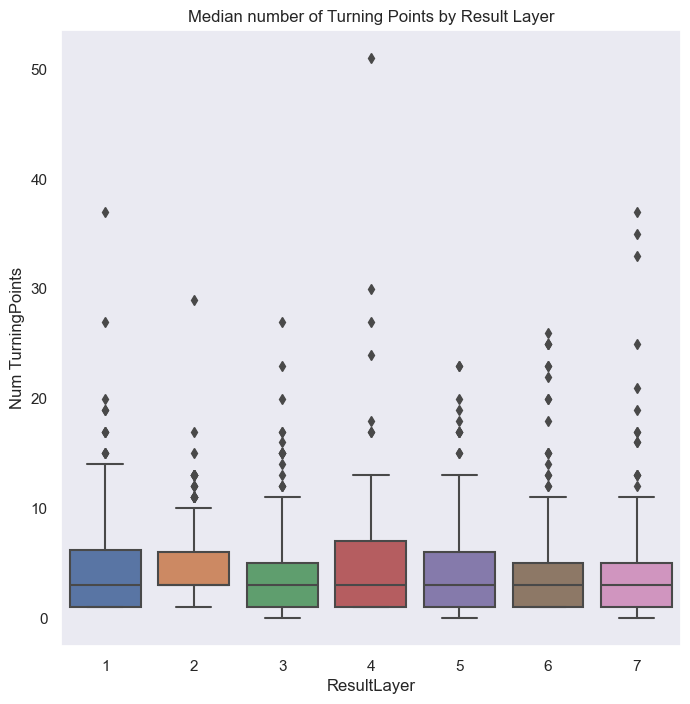

In [12]:
# Keep one row per trial-level aggregate to avoid counting duplicate peak rows.
result_partial = result_all[['ResultLayer', 'Condition', 'ProbandId', 'TrialNumber', 'Peaks_Total', 'Peaks1_Total']].drop_duplicates().reset_index()

generateBoxPlotStats(result_partial, ['ResultLayer'], ['ProbandId', 'TrialNumber'], 'Peaks_Total', 'ResultLayer', 'Num Peaks', 'Median number of Peaks by Result Layer', 'numPeaks_ResultLayer', True, True, False, True, extendedStats=False)
generateBoxPlotStats(result_partial, ['ResultLayer'], ['ProbandId', 'TrialNumber'], 'Peaks1_Total', 'ResultLayer', 'Num TurningPoints', 'Median number of Turning Points by Result Layer', 'numTurningPoints_ResultLayer', True, True, False, True, extendedStats=False)


## Detected-Layer Statistics (Raw Events)
Analyze where detected peaks and turning points occur by layer using raw peak-event rows.


Peak_Layer,0,1,2,3,4,5,6,7
count,10074,8167,8265,7025,6494,6271,6747,6255
unique,2,2,2,2,2,2,2,2
top,True,True,True,True,True,True,True,True
freq,7209,7056,6908,6239,5982,5918,6348,5235


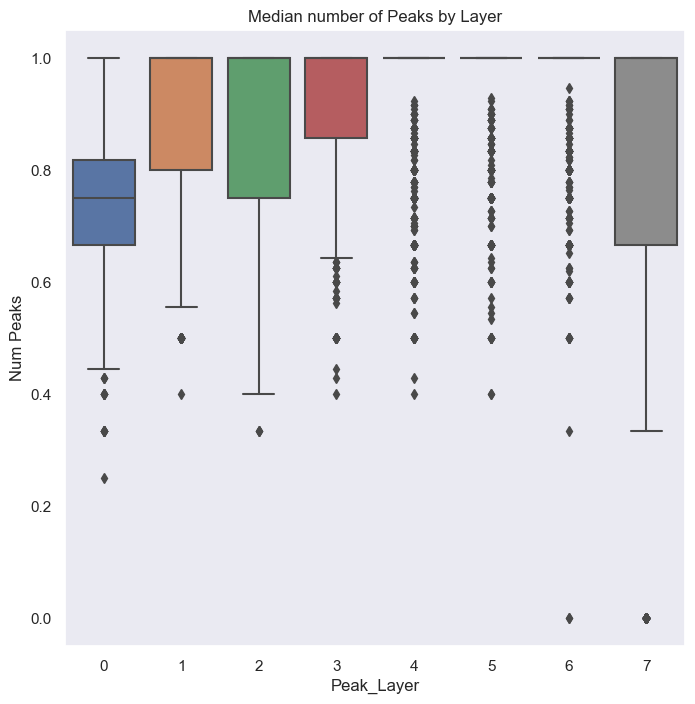

Peak_Layer,0,1,2,3,4,5,6,7
count,10074,8167,8265,7025,6494,6271,6747,6255
unique,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False
freq,7209,7056,6908,6239,5982,5918,6348,5235


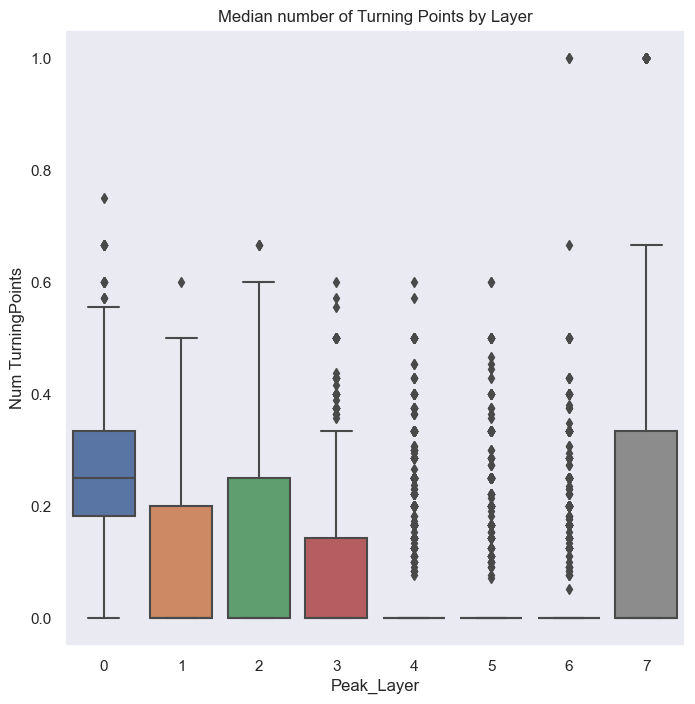

In [13]:
# Use raw peak-event rows to summarize where peaks/turning points occur by detected layer.
generateBoxPlotStats(result_all, ['Peak_Layer'], ['ProbandId', 'TrialNumber'], 'IsPeak', 'Peak_Layer', 'Num Peaks', 'Median number of Peaks by Layer', 'numPeaks_Layer', False, True, False, True, extendedStats=False)
generateBoxPlotStats(result_all, ['Peak_Layer'], ['ProbandId', 'TrialNumber'], 'IsTurningPoint', 'Peak_Layer', 'Num TurningPoints', 'Median number of Turning Points by Layer', 'numTurningPoints_Layer', False, True, False, True, extendedStats=False)


## Detected-Layer Statistics (Per Trial)
Aggregate peak events per participant/trial/layer and compute layer-based summary statistics from aggregated counts.


,Peak_Layer,ProbandId,TrialNumber,IsPeak,IsTurningPoint
0,0,2,0,10,7
1,0,2,1,4,2
2,0,2,2,5,4
3,0,2,3,8,5
4,0,2,4,6,4
...,...,...,...,...,...
14703,7,23,78,3,1
14704,7,23,79,6,4
14705,7,23,80,1,2
14706,7,23,81,3,2


Peak_Layer,0,1,2,3,4,5,6,7
count,1848.000000,1839.000000,1845.000000,1843.000000,1844.000000,1839.000000,1840.000000,1810.000000
mean,3.900974,3.836868,3.744173,3.385241,3.244035,3.218053,3.450000,2.892265
std,2.191048,2.644832,2.209628,1.906683,1.811248,1.804293,1.861344,1.984182
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,5.000000,5.000000,5.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,26.000000,27.000000,17.000000,17.000000,19.000000,17.000000,18.000000,35.000000


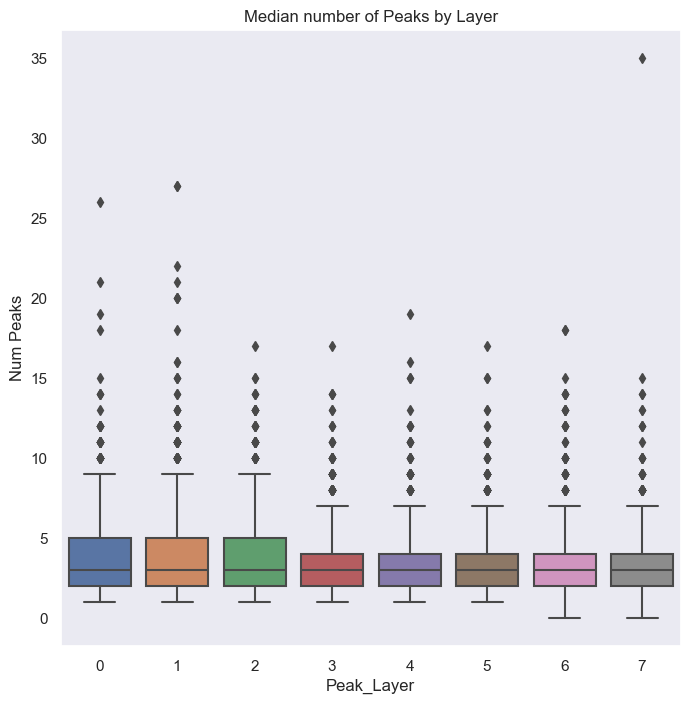

Peak_Layer,0,1,2,3,4,5,6,7
count,1848.000000,1839.000000,1845.000000,1843.000000,1844.000000,1839.000000,1840.000000,1810.000000
mean,1.550325,0.604133,0.735501,0.426479,0.277657,0.191952,0.216848,0.563536
std,1.490508,1.041523,1.170619,0.848703,0.740957,0.594333,0.649791,0.713602
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,24.000000,11.000000,12.000000,8.000000,9.000000,7.000000,8.000000,6.000000


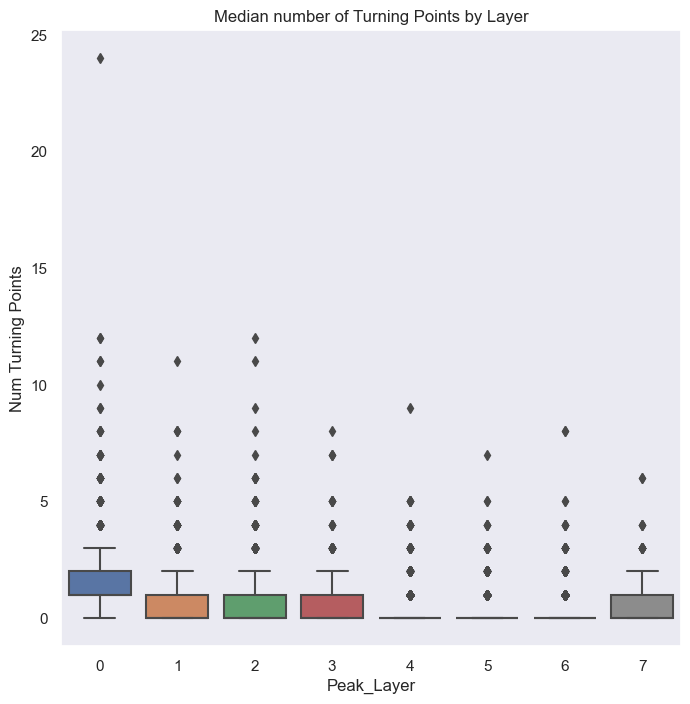

In [14]:
# Aggregate peak flags per participant/trial/layer before computing distribution stats.
peaks_grouped = result_all.groupby(['Peak_Layer', 'ProbandId', 'TrialNumber'])
peaks_per_layer = peaks_grouped[['IsPeak', 'IsTurningPoint']].sum().reset_index()

display(peaks_per_layer)

generateBoxPlotStats(peaks_per_layer, ['Peak_Layer'], ['ProbandId', 'TrialNumber'], 'IsPeak', 'Peak_Layer', 'Num Peaks', 'Median number of Peaks by Layer', 'numPeaks_Layer', True, True, False, True, extendedStats=False)
generateBoxPlotStats(peaks_per_layer, ['Peak_Layer'], ['ProbandId', 'TrialNumber'], 'IsTurningPoint', 'Peak_Layer', 'Num Turning Points', 'Median number of Turning Points by Layer', 'numTurningPoints_Layer', True, True, False, True, extendedStats=False)


## Build Peak Summary Plots
Generate grouped summary tables and regression plots for mean peak counts by result layer and condition.


ResultLayer Peaks_Total                                        
                      sum count       mean        std         var
0           1        8168   264  30.939394  12.377618  153.205438
1           2        8229   264  31.170455  11.153838  124.408097
2           3        8627   264  32.678030  12.710529  161.557538
3           4        8859   264  33.556818  14.481028  209.700181
4           5        8577   264  32.488636  13.499749  182.243216
5           6        8699   264  32.950758  16.246247  263.940532
6           7        8139   264  30.829545  13.980884  195.465131

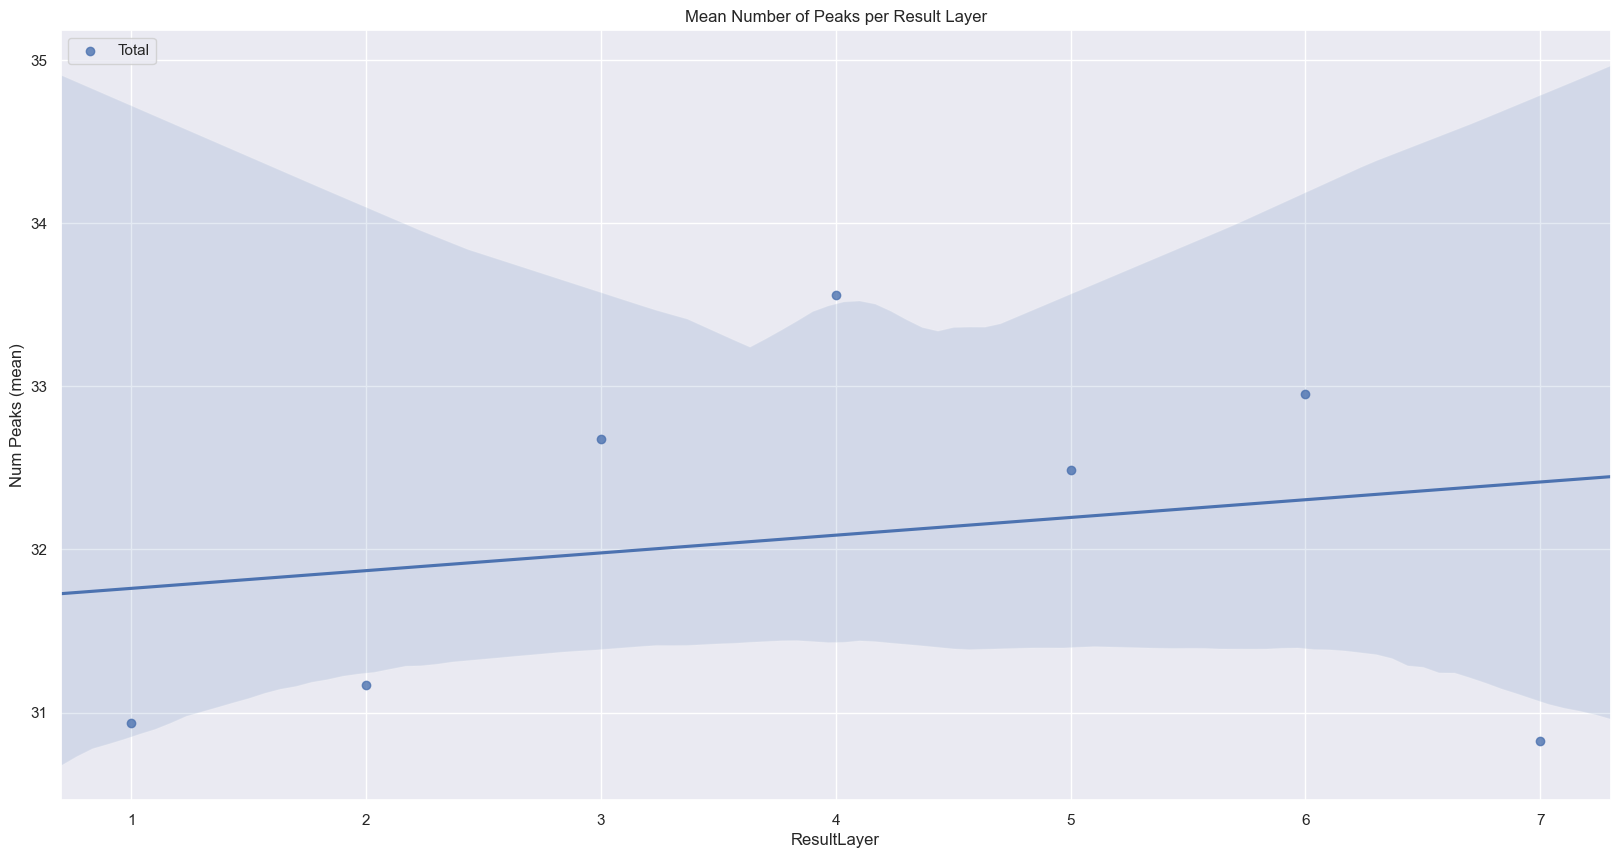

Condition ResultLayer Peaks_Total                              \
                                          sum count       mean        std   
0   Combined Feedback           1        1858    66  28.151515   6.986234   
1   Combined Feedback           2        1880    66  28.484848   8.899857   
2   Combined Feedback           3        1950    66  29.545455  11.002352   
3   Combined Feedback           4        1965    66  29.772727   9.775630   
4   Combined Feedback           5        1791    66  27.136364   8.957827   
5   Combined Feedback           6        1986    66  30.090909  16.345997   
6   Combined Feedback           7        1733    66  26.257576   7.718730   
7         No Feedback           1        2202    66  33.363636  12.681466   
8         No Feedback           2        2232    66  33.818182  10.982376   
9         No Feedback           3        2333    66  35.348485  12.100213   
10        No Feedback           4        2337    66  35.409091  18.195500   
11        No Feedback           5        2458    66  37.242424  16.479414   
12        No Feedback           6        2545    66  38.560606  18.310257   
13        No Feedback           7        2246    66  34.030303  12.588114   
14   Tactile Feedback           1        2416    66  36.606061  17.226883   
15   Tactile Feedback           2        2282    66  34.575758  13.728197   
16   Tactile Feedback           3        2426    66  36.757576  15.530675   
17   Tactile Feedback           4        2624    66  39.757576  16.570651   
18   Tactile Feedback           5        2466    66  37.363636  13.958881   
19   Tactile Feedback           6        2345    66  35.530303  17.362399   
20   Tactile Feedback           7        2358    66  35.727273  20.142222   
21    Visual Feedback           1        1692    66  25.636364   6.203315   
22    Visual Feedback           2        1835    66  27.803030   8.795488   
23    Visual Feedback           3        1918    66  29.060606   9.880640   
24    Visual Feedback           4        1933    66  29.287879   8.466704   
25    Visual Feedback           5        1862    66  28.212121   9.797198   
26    Visual Feedback           6        1823    66  27.621212   9.390282   
27    Visual Feedback           7        1802    66  27.303030   9.925832   

                
           var  
0    48.807459  
1    79.207459  
2   121.051748  
3    95.562937  
4    80.242657  
5   267.191608  
6    59.578788  
7   160.819580  
8   120.612587  
9   146.415152  
10  331.076224  
11  271.571096  
12  335.265501  
13  158.460606  
14  296.765501  
15  188.463403  
16  241.201865  
17  274.586480  
18  194.850350  
19  301.452914  
20  405.709091  
21   38.481119  
22   77.360606  
23   97.627040  
24   71.685082  
25   95.985082  
26   88.177389  
27   98.522145

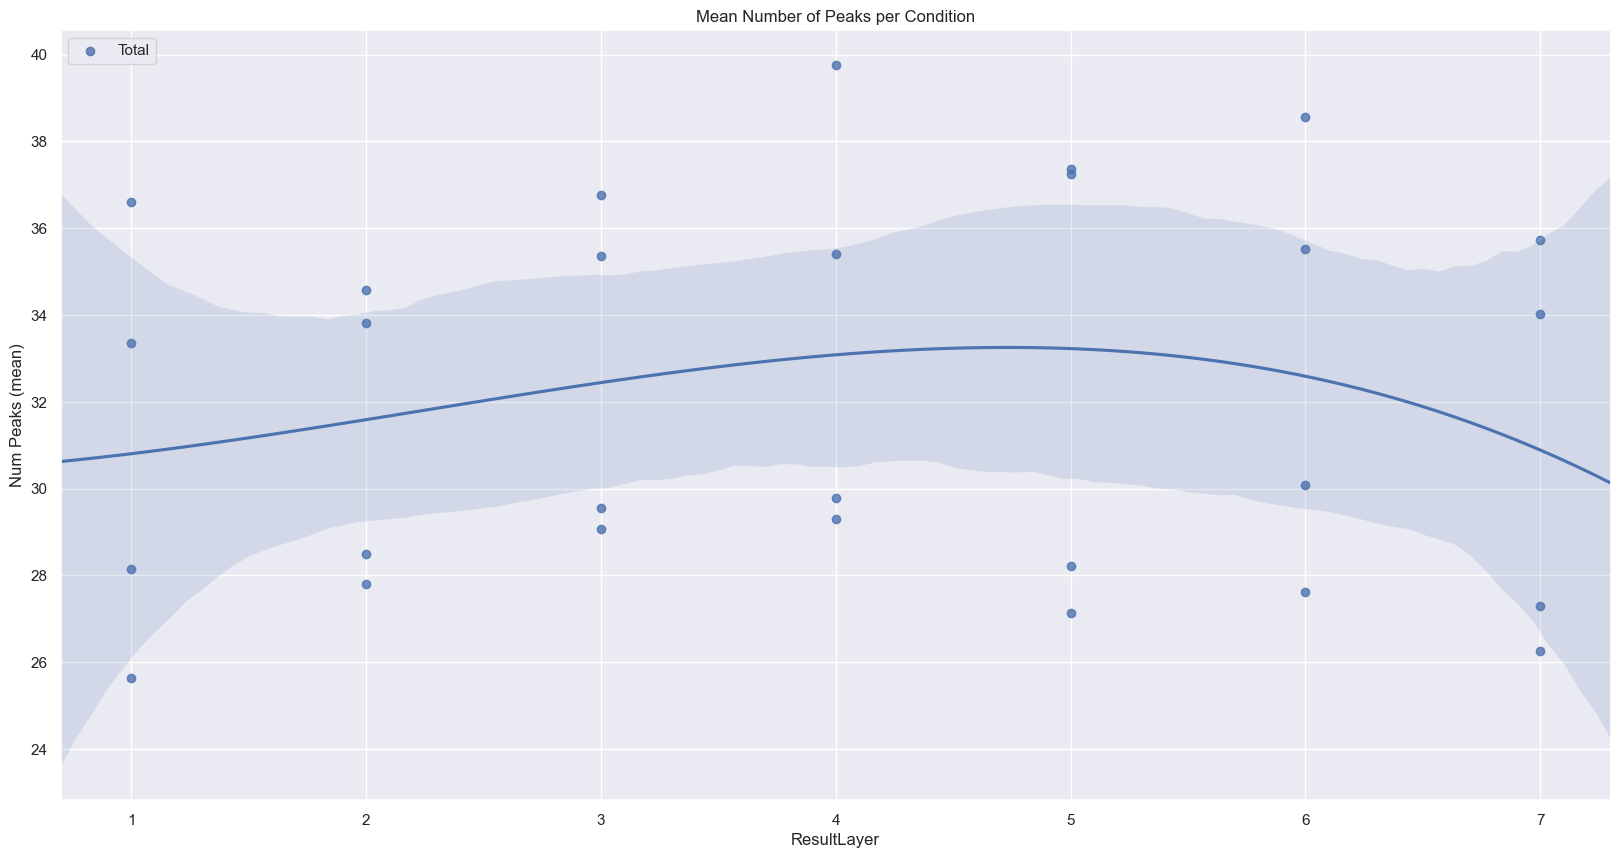

Condition Peaks_Total                                        
                             sum count       mean        std         var
0  Combined Feedback       13163   462  28.491342  10.379509  107.734198
1        No Feedback       16353   462  35.396104  14.766477  218.048835
2   Tactile Feedback       16917   462  36.616883  16.452864  270.696721
3    Visual Feedback       12865   462  27.846320   9.018911   81.340756

,index,Condition,ProbandId,TrialNumber,ResultLayer,Peaks_Total,Peaks1_Total
0,0,No Feedback,2,0,5,83,17
1,0,No Feedback,2,1,3,34,5
2,0,No Feedback,2,2,5,58,11
3,0,No Feedback,2,3,3,60,17
4,0,No Feedback,2,4,7,51,7
...,...,...,...,...,...,...,...
1843,0,No Feedback,23,79,7,38,10
1844,0,No Feedback,23,80,5,27,3
1845,0,No Feedback,23,81,6,57,9
1846,0,No Feedback,23,82,1,41,11


In [15]:
peaks = loadPeaks()

# Deduplicate to one row per trial summary before grouped aggregation.
peaks = result_all[['Condition', 'ProbandId', 'TrialNumber', 'ResultLayer', 'Peaks_Total', 'Peaks1_Total']].drop_duplicates().reset_index()

# Aggregate statistics by result layer.
grouped_layers = peaks.groupby(["ResultLayer"])[["Peaks_Total"]].agg(["sum", "count", "mean", "std", "var"]).reset_index()

display(grouped_layers)

fig_layer = plt.figure(figsize=(20,10))

ax_layer = sns.regplot(x=grouped_layers["ResultLayer"], y=grouped_layers["Peaks_Total"]["mean"], truncate=False, label='Total')

ax_layer.xaxis.set_major_locator(MultipleLocator(1))
ax_layer.set_ylabel('Num Peaks (mean)')

ax_layer.legend(loc='upper left')

plt.title('Mean Number of Peaks per Result Layer')

plt.savefig(rf'{export_img}peaks_layer.png')
plt.savefig(rf'{export_img}peaks_layer.svg')
plt.show()

# Aggregate statistics by condition and result layer.
grouped_condition_layer = peaks.groupby(["Condition", "ResultLayer"])[["Peaks_Total"]].agg(["sum", "count", "mean", "std", "var"]).reset_index()

display(grouped_condition_layer)

fig_condition_layer = plt.figure(figsize=(20,10))

ax_condition_layer = sns.regplot(x=grouped_condition_layer["ResultLayer"], y=grouped_condition_layer["Peaks_Total"]["mean"], order=3, truncate=False, label='Total')

ax_condition_layer.xaxis.set_major_locator(MultipleLocator(1))
ax_condition_layer.set_ylabel('Num Peaks (mean)')

ax_condition_layer.legend(loc='upper left')

plt.title('Mean Number of Peaks per Condition')

plt.savefig(rf'{export_img}peaks_layer_mapping.png')
plt.savefig(rf'{export_img}peaks_layer_mapping.svg')
plt.show()

# Aggregate statistics by condition only.
grouped_condition = peaks.groupby(["Condition"])[["Peaks_Total"]].agg(["sum", "count", "mean", "std", "var"]).reset_index()

display(grouped_condition)

# fig_condition = plt.figure(figsize=(20,10))

# ax_condition = sns.regplot(x=grouped_condition["Condition"], y=grouped_condition["Peaks_Total"]["mean"], truncate=False, label='Total')

# ax_condition.xaxis.set_major_locator(MultipleLocator(1))
# ax_condition.set_ylabel('Num Peaks (mean)')

# ax_condition.legend(loc='upper left')

# plt.title('Mean Number of Peaks by Condition and Result Layer')

# plt.savefig(rf'{export_img}peaks_targetLayer.png')
# plt.savefig(rf'{export_img}peaks_targetLayer.svg')
# plt.show()

# peaks['Peaks_Layer_complete'] = peaks['Peaks_Layer_complete'].explode()
display(peaks)

# peaks.pivot_table(columns= ['Layer'])


## Export Interaction Graphs for All Trials
Loop through participants, blocks, and experiment trials to render single-trial graphs and capture trimmed interaction durations.


In [ ]:
all_participants = np.array(data_complete["ProbandId"].drop_duplicates().sort_values())
all_experiment_trials = np.array(data_complete[data_complete['TrialNumber'] >= 0]['Trial'].drop_duplicates().sort_values())
all_blocks = np.array(data_complete[data_complete['Block'] >= 0]["Block"].drop_duplicates().sort_values())

results = pd.read_csv(rf'{export_data}results_experiment.csv', sep=";")

duration_complete = []

# Render and export per-trial interaction plots for all experiment trials.
for p in all_participants:
    for b in all_blocks:
        display(f'Proband: {p}, Block: {b}')
        for tId in all_experiment_trials:
            # Reconstruct global trial number from block-local trial index.
            t = (len(all_experiment_trials) * b) + tId
            duration = drawInteractionGraph(p, t)
